# Chron.jl standalone age-depth model with simple Gaussian age constraints

This Jupyter notebook demonstrates an example age-depth model using [Chron.jl](https://github.com/brenhinkeller/Chron.jl). For more information, see [github.com/brenhinkeller/Chron.jl](https://github.com/brenhinkeller/Chron.jl) and [doi.org/10.17605/osf.io/TQX3F](https://doi.org/10.17605/osf.io/TQX3F). 

<a href="https://mybinder.org/v2/gh/brenhinkeller/Chron.jl/main?filepath=examples%2FChron1.0StratOnly.ipynb" target="_blank"><img src="https://static.mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***

## Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
try
    using Chron
catch
    using Pkg
    Pkg.add("Chron")
    using Chron
end

using Statistics, StatsBase, DelimitedFiles, SpecialFunctions
using Plots; gr(); default(fmt = :png)

***
## Enter sample information
Paste your data in here!

In [2]:
# Input the number of samples we wish to model (must match below)
nSamples = 14

# Make an instance of a ChronSection object for nSamples
smpl = NewChronAgeData(nSamples)
smpl.Name          = ("BV9a2_1", "BV9a2_2", "BV9a2_3", "BV9a2_4", "BV9a2_5", "BV9a2_6", "BV9a2_7", "BV9a2_8", "BV9a2_9", "BV9a2_10", "BV9a2_11", "BV9a2_12", "BV9a2_13", "BV9a2_14",) # Et cetera
smpl.Age           = [ 17.054, 17.284, 17.299, 17.468, 19.359, 20.137, 20.144, 21.113, 21.681, 23.154, 23.954, 24.634, 24.635, 27.641] # Measured ages
smpl.Age_sigma     = [0.332, 0.449, 0.230, 0.219, 0.265, 0.249, 0.273, 0.283, 1.883, 0.252, 0.231, 0.135, 0.221, 2.147] # Measured 1-σ uncertainties
smpl.Height[:]     = [      -1,      -2,      -3,      -5,      -6.5,      -7.5,      -8,      -9,      -10.5,      -12,      -13,      -14,      -14.5,      -15.5,] # Depths below surface should be negative
smpl.Height_sigma[:]  = fill(0.01, nSamples) # Usually assume little or no sample height uncertainty
smpl.Age_Sidedness[:] = zeros(nSamples) # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "MyData/" # Where do you want output files to be stored

smpl.Age_Unit = "ka"; # Unit of measurement for ages
smpl.Height_Unit = "m"; # Unit of measurement for Height and Height_sigma

Note that smpl.Height *must* increase with increasing stratigraphic height -- i.e., stratigraphically younger samples must be more positive. For this reason, it is convenient to represent depths below surface as negative numbers.

***
## Option A: Configure and run stratigraphic model, no hiatuses

To run the stratigraphic MCMC model, we call the `StratMetropolis` function, which uses the Gaussian mean age and standard deviation set in `smpl.Age` and `smpl.Age_sigma`

Burn-in... 100%|█████████████████████████████████████████| Time: 0:00:00
Collecting... 100%|██████████████████████████████████████| Time: 0:00:00


Generating stratigraphic age-depth model...
Burn-in: 1460000 steps


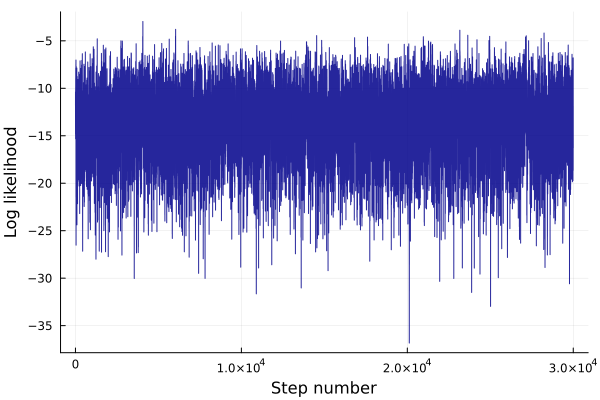

In [11]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If in doubt, you can probably leave these parameters as-is
config.resolution = 0.2 # Same units as sample height. Smaller is slower!
config.bounding = 0.5 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolis(smpl, config)

# Write the results to file
run(`mkdir -p $(smpl.Path)`) # Make sure that the path exists
writedlm(smpl.Path*"agedist.csv", agedist, ',') # Stationary distribution of the age-depth model
writedlm(smpl.Path*"height.csv", mdl.Height, ',') # Stratigraphic heights corresponding to each row of agedist
writedlm(smpl.Path*"age.csv", mdl.Age, ',') # Mean age of resulting model
writedlm(smpl.Path*"age_025CI.csv", mdl.Age_025CI, ',') # 2.5% confidence interval of resulting model
writedlm(smpl.Path*"age_975CI.csv", mdl.Age_975CI, ',') # 97.5% confidence interval of resulting model
writedlm(smpl.Path*"lldist.csv", lldist, ',') # Log likelihood distribution (to check for stationarity)

# Plot the log likelihood to make sure we're converged (n.b burnin isn't recorded)
hdl = plot(lldist,xlabel="Step number",ylabel="Log likelihood",label="",line=(0.85,:darkblue))
savefig(hdl,smpl.Path*"lldist.pdf")
display(hdl)

The most important output of this process is `agedist`, which contains the full stationary distribution of the age-depth model. We can save it to a file, but if this notebook is running remotely, you may have trouble getting it out of here (see section **Getting your data out**)!
***
## Plot results

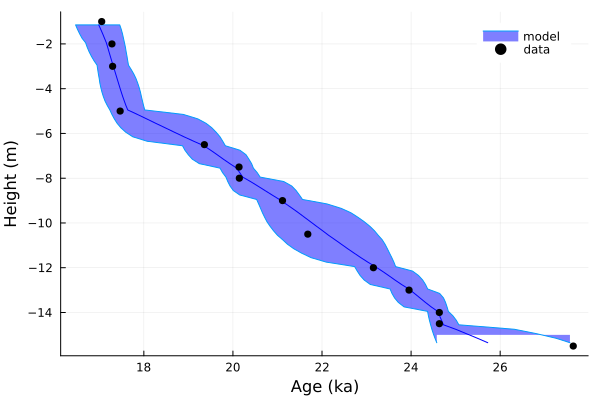

In [12]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(round(Int,minimum(mdl.Height)),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white) # Center line
t = smpl.Age_Sidedness .== 0 # Two-sided constraints (plot in black)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],smpl.Age_975CI[t]-smpl.Age[t]),label="data",seriestype=:scatter,color=:black)
t = smpl.Age_Sidedness .== 1 # Minimum ages (plot in cyan)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],zeros(count(t))),label="",seriestype=:scatter,color=:cyan,msc=:cyan)
any(t) && zip(smpl.Age[t], smpl.Age[t].+nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:cyan)
t = smpl.Age_Sidedness .== -1 # Maximum ages (plot in orange)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(zeros(count(t)),smpl.Age_975CI[t]-smpl.Age[t]),label="",seriestype=:scatter,color=:orange,msc=:orange)
any(t) && zip(smpl.Age[t], smpl.Age[t].-nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:orange)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")
savefig(hdl,smpl.Path*"AgeDepthModel.svg")
savefig(hdl,smpl.Path*"AgeDepthModel.pdf")
display(hdl)

Interpolated age at height=-404: 478.16838457212725 +160.24071034689405/-374.37498124215927 ka

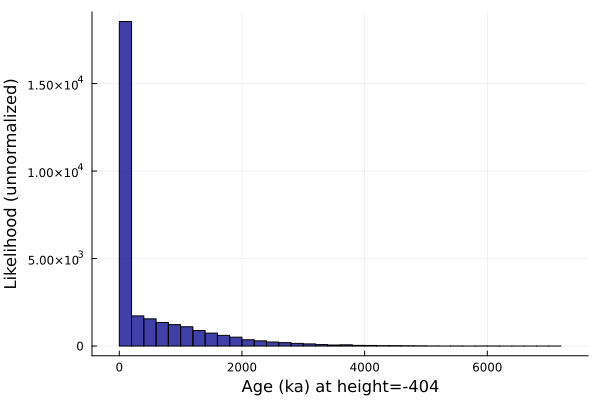

In [13]:
# Stratigraphic height at which to interpolate
height = -404

age_at_height = linterp1s(mdl.Height,mdl.Age,height)
age_at_height_min = linterp1s(mdl.Height,mdl.Age_025CI,height)
age_at_height_max = linterp1s(mdl.Height,mdl.Age_975CI,height)
print("Interpolated age at height=$height: $age_at_height +$(age_at_height_max-age_at_height)/-$(age_at_height-age_at_height_min) $(smpl.Age_Unit)")

# Optional: interpolate full age distribution
interpolated_distribution = Array{Float64}(undef,size(agedist,2))
for i=1:size(agedist,2)
    interpolated_distribution[i] = linterp1s(mdl.Height,agedist[:,i],height)
end
hdl = histogram(interpolated_distribution, nbins=50, fill=(0.75,:darkblue), label="")
plot!(hdl, xlabel="Age ($(smpl.Age_Unit)) at height=$height", ylabel="Likelihood (unnormalized)")

There are other things we can plot as well, such as deposition rate:

  0.158796 seconds (777.45 k allocations: 217.399 MiB, 17.85% gc time)


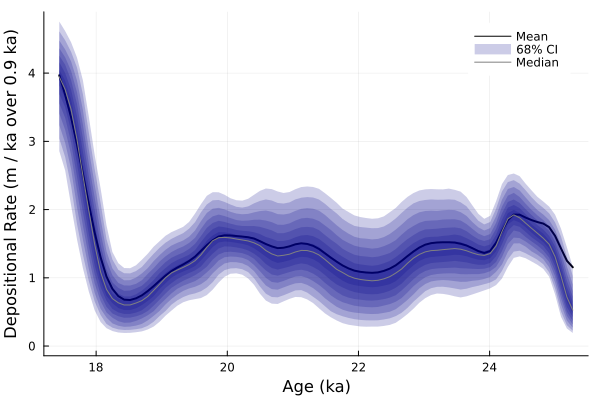

In [14]:
# Set bin width and spacing
binwidth = round(nanrange(mdl.Age)/10,sigdigits=1) # Can also set manually, commented out below
# binwidth = 100 # Same units as smpl.Age
binoverlap = 10
ages = collect(minimum(mdl.Age):binwidth/binoverlap:maximum(mdl.Age))
bincenters = ages[1+Int(binoverlap/2):end-Int(binoverlap/2)]
spacing = binoverlap

# Calculate rates for the stratigraphy of each markov chain step
dhdt_dist = Array{Float64}(undef, length(ages)-binoverlap, config.nsteps)
@time for i=1:config.nsteps
    heights = linterp1(reverse(agedist[:,i]), reverse(mdl.Height), ages)
    dhdt_dist[:,i] .= abs.(heights[1:end-spacing] - heights[spacing+1:end]) ./ binwidth
end

# Find mean and 1-sigma (68%) CI
dhdt = nanmean(dhdt_dist,dim=2)
dhdt_50p = nanmedian(dhdt_dist,dim=2)
dhdt_16p = nanpctile(dhdt_dist,15.865,dim=2) # Minus 1-sigma (15.865th percentile)
dhdt_84p = nanpctile(dhdt_dist,84.135,dim=2) # Plus 1-sigma (84.135th percentile)
# Other confidence intervals (10:10:50)
dhdt_20p = nanpctile(dhdt_dist,20,dim=2)
dhdt_80p = nanpctile(dhdt_dist,80,dim=2)
dhdt_25p = nanpctile(dhdt_dist,25,dim=2)
dhdt_75p = nanpctile(dhdt_dist,75,dim=2)
dhdt_30p = nanpctile(dhdt_dist,30,dim=2)
dhdt_70p = nanpctile(dhdt_dist,70,dim=2)
dhdt_35p = nanpctile(dhdt_dist,35,dim=2)
dhdt_65p = nanpctile(dhdt_dist,65,dim=2)
dhdt_40p = nanpctile(dhdt_dist,40,dim=2)
dhdt_60p = nanpctile(dhdt_dist,60,dim=2)
dhdt_45p = nanpctile(dhdt_dist,45,dim=2)
dhdt_55p = nanpctile(dhdt_dist,55,dim=2)

# Plot results
hdl = plot(bincenters,dhdt, label="Mean", color=:black, linewidth=2)
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_16p; reverse(dhdt_84p)], fill=(0,0.2,:darkblue), linealpha=0, label="68% CI")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_20p; reverse(dhdt_80p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_25p; reverse(dhdt_75p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_30p; reverse(dhdt_70p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_35p; reverse(dhdt_65p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_40p; reverse(dhdt_60p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_45p; reverse(dhdt_55p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,bincenters,dhdt_50p, label="Median", color=:grey, linewidth=1)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Depositional Rate ($(smpl.Height_Unit) / $(smpl.Age_Unit) over $binwidth $(smpl.Age_Unit))", fg_color_legend=:white)
savefig(hdl,smpl.Path*"DepositionRateModelCI.pdf")
display(hdl)

In [ ]:
data = [bincenters, dhdt]
writedlm("MyData/BV9a2_deposition.csv", data, ',')

***
## Option B: Configure and run stratigraphic model, including hiatuses
We can also deal with discrete hiatuses in the stratigraphic section if we know where they are and about how long they lasted. We need some different models and methods though. In particular, in addition to the `ChronAgeData` struct, we also need a `HiatusData` struct now, and will have a new `hiatusdist` output.

Generating stratigraphic age-depth model...
Burn-in: 3400000 steps


Burn-in...100%|█████████████████████████████████████████| Time: 0:00:02


Collecting...100%|██████████████████████████████████████| Time: 0:00:07


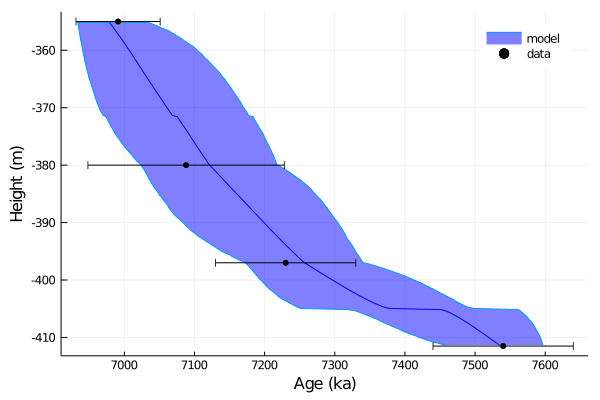

In [7]:
# Data about hiatuses
nHiatuses = 2 # The number of hiatuses you have data for
hiatus = NewHiatusData(nHiatuses) # Struct to hold data
hiatus.Height         = [-371.5, -405.0 ]
hiatus.Height_sigma   = [   0.0,    0.0 ]
hiatus.Duration       = [ 100.0,   123.0]
hiatus.Duration_sigma = [  30.5,    20.0]

# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If in doubt, you can probably leave these parameters as-is
config.resolution = 0.2 # Same units as sample height. Smaller is slower!
config.bounding = 0.1 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the model. Note the new `hiatus` argument and `hiatusdist` result
(mdl, agedist, hiatusdist, lldist) = StratMetropolis(smpl, hiatus, config); sleep(0.5)

# Write the results to file
run(`mkdir -p $(smpl.Path)`) # Make sure that the path exists
writedlm(smpl.Path*"agedist_hiatus.csv", agedist, ',') # Stationary distribution of the age-depth model
writedlm(smpl.Path*"height_hiatus.csv", mdl.Height, ',') # Stratigraphic heights corresponding to each row of agedist
writedlm(smpl.Path*"age_hiatus.csv", mdl.Age, ',') # Mean age of resulting model
writedlm(smpl.Path*"age_025CI_hiatus.csv", mdl.Age_025CI, ',') # 2.5% confidence interval of resulting model
writedlm(smpl.Path*"age_975CI_hiatus.csv", mdl.Age_975CI, ',') # 97.5% confidence interval of resulting model
writedlm(smpl.Path*"lldist_hiatus.csv", lldist, ',') # Log likelihood distribution (to check for stationarity)

# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white)
plot!(hdl, smpl.Age, smpl.Height, xerror=smpl.Age_sigma*2,label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")
savefig(hdl,smpl.Path*"AgeDepthModelHiatus.pdf");
display(hdl)

***
## Getting your data out
As shown below, we have access to the system command line, so we can use the unix command `ls` to see all the files we have written. We'll try this first using `;` to access Julia's command-line shell mode:

In [8]:
; ls MyData

AgeDepthModel.pdf
AgeDepthModel.svg
AgeDepthModelHiatus.pdf
DepositionRateModelCI.pdf
age.csv
age_025CI.csv
age_025CI_hiatus.csv
age_975CI.csv
age_975CI_hiatus.csv
age_hiatus.csv
agedist.csv
agedist_hiatus.csv
height.csv
height_hiatus.csv
lldist.csv
lldist.pdf
lldist_hiatus.csv


Alternatively, we could do the same thing using the `run` function:

In [9]:
run(`ls MyData`)

AgeDepthModel.pdf
AgeDepthModel.svg
AgeDepthModelHiatus.pdf
DepositionRateModelCI.pdf
age.csv
age_025CI.csv
age_025CI_hiatus.csv
age_975CI.csv
age_975CI_hiatus.csv
age_hiatus.csv
agedist.csv
agedist_hiatus.csv
height.csv
height_hiatus.csv
lldist.csv
lldist.pdf
lldist_hiatus.csv


Process(`ls MyData`, ProcessExited(0))

If you're running this notebook online, getting these files out of here may be harder though. For SVG files, one option is to view them in markdown cells, which you should then be able to right click and download as real vector graphics. e.g. pasting something like
```
<img src="AgeDepthModel.svg" align="left" width="600"/>
```
in a markdown cell such as this one

Meanwhile, for the csv files we could try something like `; cat agedist.csv`, but agedist is probably too big to print. Let's try using ffsend instead, which should give you a download link. In fact, while we're at it, we might as well archive and zip the entire directory!

In [10]:
# Make gzipped tar archive of the the whole MyData directory
run(`tar -zcf archive.tar.gz ./MyData`);

In [11]:
# Download prebuilt ffsend linux binary
download("https://github.com/timvisee/ffsend/releases/download/v0.2.65/ffsend-v0.2.65-linux-x64-static", "ffsend")

# Make ffsend executable
run(`chmod +x ffsend`);

In [12]:
; ./ffsend upload archive.tar.gz

You could alternatively use the ffsend command in this way to transfer individual files, for instance `; ./ffsend upload MyData/agedist.csv`

Keep in mind that any changes you make to this online notebook won't persist after you close the tab (or after it times out) even if you save your changes! You have to either copy-paste or `file`>`Download as` a copy.
*** 
[![DOI](https://raw.githubusercontent.com/brenhinkeller/Chron.jl/main/readme_figures/osf_io_TQX3F.svg?sanitize=true)](https://doi.org/10.17605/osf.io/TQX3F)